In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import snap

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

%matplotlib inline

In [2]:
# data import
features = pd.read_csv('followers_network.emb', sep=' ',header=None,skiprows=1)
nodes = pd.read_csv('data/followers_network_nodes.csv', sep='\t')

/home/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = nodes.merge(features, left_on='id', right_on=0)

In [4]:
tags = data[data['type'] == 'tag']
tags.drop(['type',0], axis=1, inplace=True)

/home/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
tags.head()

,id,content,id_node,1,2,3,4,5,6,7,8
224698,224700,tasselearrings,tasselearrings,-1.001210,0.131172,-2.91619,-2.25687,-1.267730,-0.084874,-0.349034,1.51345
224699,224701,gxgcollective,gxgcollective,-1.562770,0.487267,-2.61295,-3.52739,-0.805257,-0.258644,-0.101190,1.72735
224700,224702,australianbrand,australianbrand,-1.563800,0.538218,-2.72160,-3.51718,-0.838224,-0.321005,-0.150489,1.63644
224701,224703,wanderlust,wanderlust,-0.770500,0.366655,-1.74490,-1.81762,-0.244702,-0.157471,-0.162480,1.31579
224702,224706,turquoise,turquoise,-0.888139,0.143265,-1.27237,-2.42818,-0.998081,-0.067536,0.314245,1.26193


### Analysis of data points density to select parameters for DBSCAN

In [6]:
distMatrix = squareform(pdist(tags[range(1,9)]))

In [7]:
def getKgraph(dist_matrix, k):
    k_graph = []
    for i in range(tags.shape[0]):
        knn_dist = np.mean(sorted(distMatrix[i])[1:K+1])
        k_graph.append(knn_dist)
    return k_graph

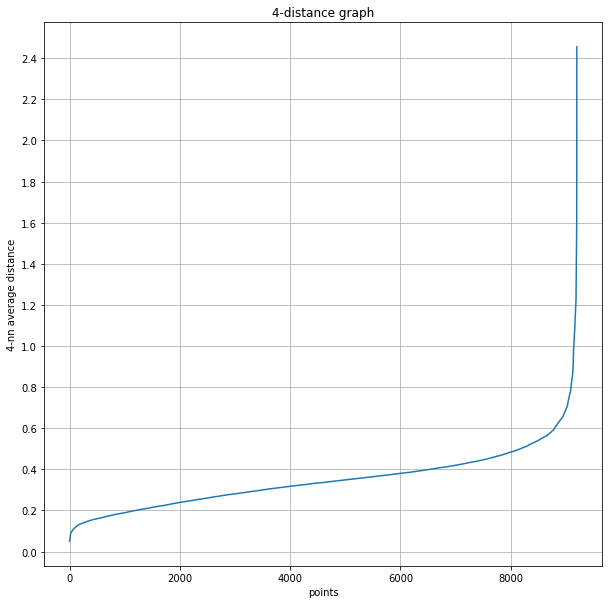

In [8]:
K = 4
k_graph = getKgraph(distMatrix, K)

plt.figure(figsize=(10,10))
plt.title('{}-distance graph'.format(K))
plt.xlabel('points')
plt.ylabel('{}-nn average distance'.format(K))

plt.plot(sorted(k_graph))
plt.yticks(np.arange(0, max(k_graph), step=0.2))
plt.grid(True)

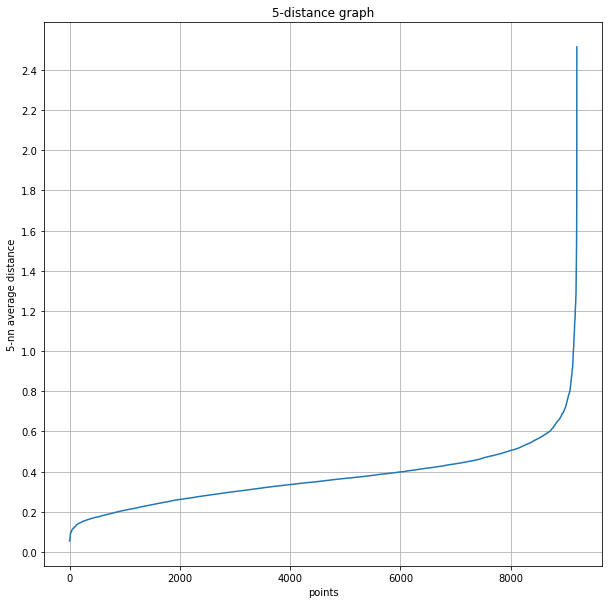

In [9]:
K = 5
k_graph = getKgraph(distMatrix, K)

plt.figure(figsize=(10,10))
plt.title('{}-distance graph'.format(K))
plt.xlabel('points')
plt.ylabel('{}-nn average distance'.format(K))

plt.plot(sorted(k_graph))
plt.yticks(np.arange(0, max(k_graph), step=0.2))
plt.grid(True)

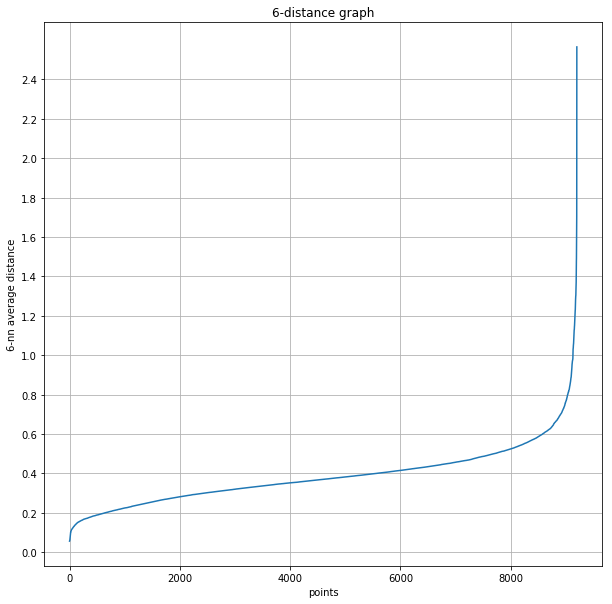

In [10]:
K = 6
k_graph = getKgraph(distMatrix, K)

plt.figure(figsize=(10,10))
plt.title('{}-distance graph'.format(K))
plt.xlabel('points')
plt.ylabel('{}-nn average distance'.format(K))

plt.plot(sorted(k_graph))
plt.yticks(np.arange(0, max(k_graph), step=0.2))
plt.grid(True)

From the plot, eps = 0.6 seems a good choice. For what concern the other parameter, we try to use minPts = 10: this parameter can be tuned in order to obtain fewer clusters and in the previous test run, using 10, we obtained 52 clusters.

### DBSCAN

In [6]:
# First test
epsilon = 0.6
minPts = 15
db = DBSCAN(eps = epsilon, min_samples = minPts, n_jobs = -1).fit(tags[range(1,9)])

In [7]:
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print 'Estimated number of clusters: {}'.format(n_clusters)

Estimated number of clusters: 30


In [8]:
tags['cluster'] = labels

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


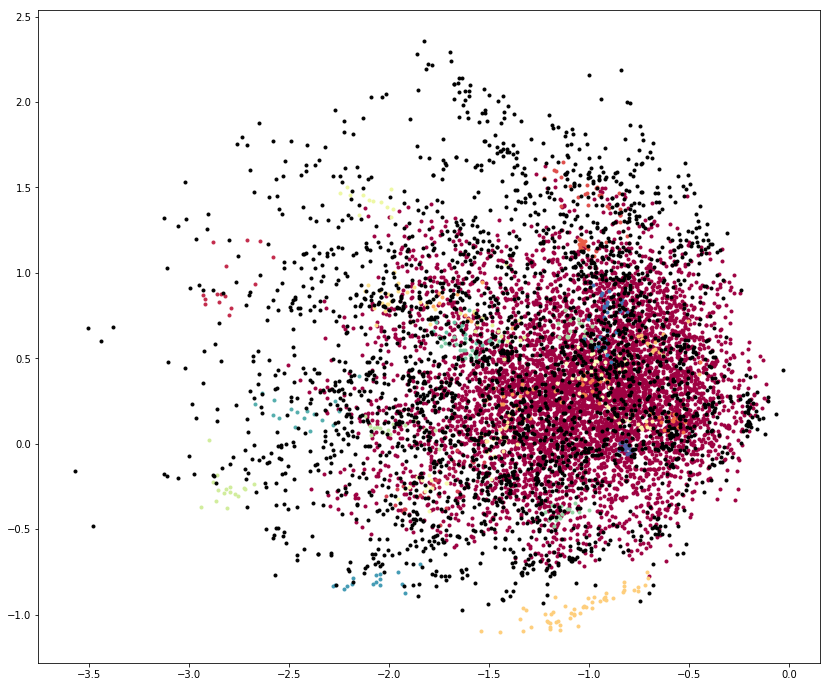

In [9]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(14,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    
    cluster = tags[tags['cluster'] == k]
    plt.scatter(cluster[1], cluster[2], marker='.', color=col)

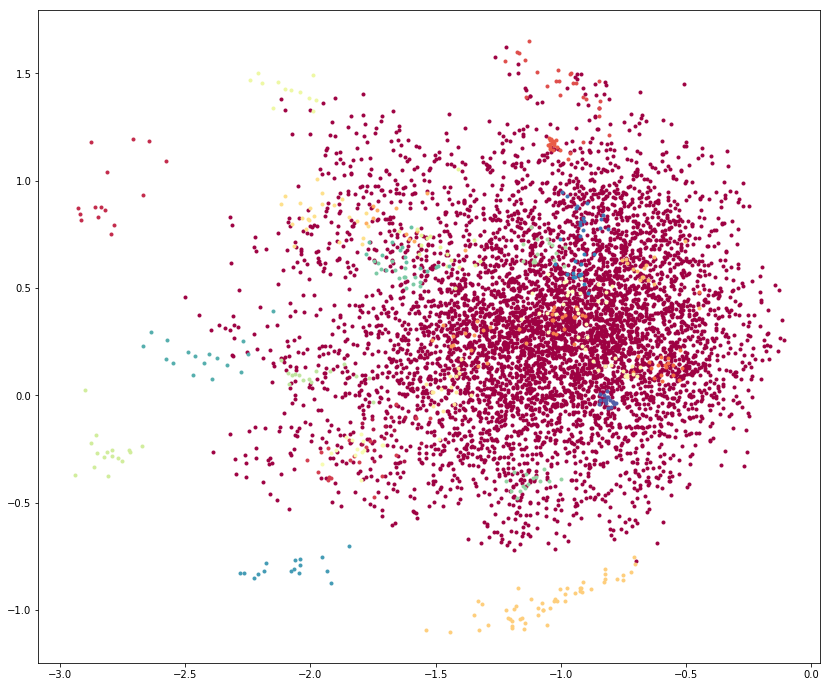

In [10]:
plt.figure(figsize=(14,12))
for k, col in zip(unique_labels, colors):
    if k != -1:
        cluster = tags[tags['cluster'] == k]
        plt.scatter(cluster[1], cluster[2], marker='.', color=col)

In [11]:
sizes = []
for c in range(n_clusters):
    cluster = tags[tags['cluster'] == c]
    sizes.append(cluster.shape[0])

<BarContainer object of 30 artists>

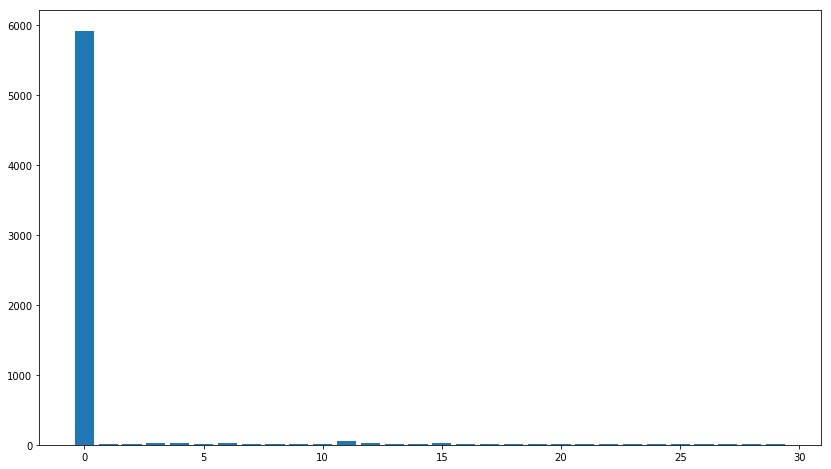

In [12]:
plt.figure(figsize=(14,8))
plt.bar(range(n_clusters), sizes)

In [13]:
for n in range(-1, n_clusters):
    print n, tags[tags['cluster'] == n].shape[0]

-1 2773
0 5916
1 15
2 15
3 19
4 25
5 17
6 19
7 16
8 15
9 11
10 15
11 52
12 23
13 15
14 17
15 23
16 15
17 12
18 17
19 16
20 15
21 15
22 15
23 15
24 15
25 17
26 16
27 15
28 15
29 17


In [19]:
with open('output/1_step_tags_clusters.txt', 'w') as outfile:
    outfile.write('n_cluster\tdim\thashtags\n')
    for c in range(-1, n_clusters):
        cluster = tags[tags['cluster'] == c]
        dim = cluster.shape[0]
        if dim<100:
            outfile.write('{}\t{}\t{}\n'.format(c, dim, ','.join(list(cluster['content']))))
        else:
            outfile.write('{}\t{}\t{}\n'.format(c, dim, '/'))

Try to extract user participation in these clusters as the percentage of tags used by each user that are contained in a specific cluster.

In [68]:
# extract list of tags for each user
path = 'data/'

# read input network
t_net = snap.LoadEdgeListNet(path+'followers_network.csv', '\t')

usedtags = {}

it = t_net.BegNI()
V = t_net.GetNodes()
for i in range(V):
    nid = it.GetId()
    type = t_net.GetStrAttrDatN(nid, 'type')
    username = t_net.GetStrAttrDatN(nid, 'content')

    if type == 'user':
        tagsV = snap.TIntV()
        snap.GetNodesAtHop(t_net, nid, 2, tagsV, True)
        
        taglist = []
        for tid in tagsV:
            tagname = t_net.GetStrAttrDatN(tid, 'content')
            taglist.append(tagname)
            
        usedtags[username] = set(taglist)
    it.Next()

In [21]:
# extract list of tags for each cluster
clusterTags = {}
for c in range(-1, n_clusters):
    cluster = tags[tags['cluster'] == c]
    clusterTags[c] = set(cluster['content'])

In [25]:
# compute participation of each user in each of the 30 cluster (plus the "noise cluster")
tempResult = []
for u in usedtags:
    u_vector = usedtags[u]
    
    if len(u_vector)>0:
        u_result = [u]
        for c in range(-1, n_clusters):
            c_vector = clusterTags[c]
            participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
            u_result.append(participation)
    else:
        u_result = [u]+[0 for i in range(-1, n_clusters)]
    tempResult.append(tuple(u_result))

In [27]:
result_header = ['username', 'noise']+[c for c in range(n_clusters)]
participationTable = pd.DataFrame(tempResult, columns=result_header)

In [28]:
participationTable.head()

,username,noise,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,martaferrari9008,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rsersale,0.058824,0.941176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tlashab,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,charr114,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,catespin,0.000000,0.941176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
for i in range(1, n_clusters):
    print participationTable[participationTable[i] != 0.0].shape[0]

2
6
11
17
1
5
1
3
6
27
16
9
6
4
10
6
3
6
2
3
1
4
1
7
8
12
1
1
1


In [51]:
participationTable.to_csv('output/1_step_user_participation.csv', index=None)

### User participation analysis

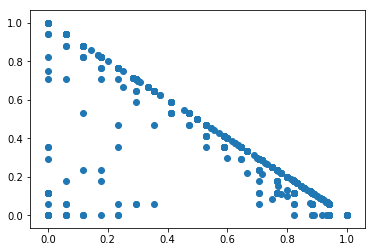

In [120]:
plt.scatter(participationTable[0], participationTable['noise'])

In [127]:
with open('output/1_step_user_groups.csv', 'w') as outfile:
    outfile.write('id_cluster\tnum_users\tlist_users\n')
    for i in range(1, 30):
        group = participationTable[participationTable[i] != 0.0]
        group.sort_values(by=i, ascending = False, inplace=True)
        
        dim = group.shape[0]
        userlist = list(group.apply(lambda x: tuple((x['username'], x[i])), axis=1))
        outfile.write('{}\t{}\t{}\n'.format(i, dim, str(userlist).strip('[]')))

### Further Inspection: Cluster 0 and -1

The biggest cluster contains all the hashtags used by regular users: we need to check if it is possible to extract some patterns from this macrogroup, too. We already verified with a few tries that DBSCAN cannot extract anything meaningful.

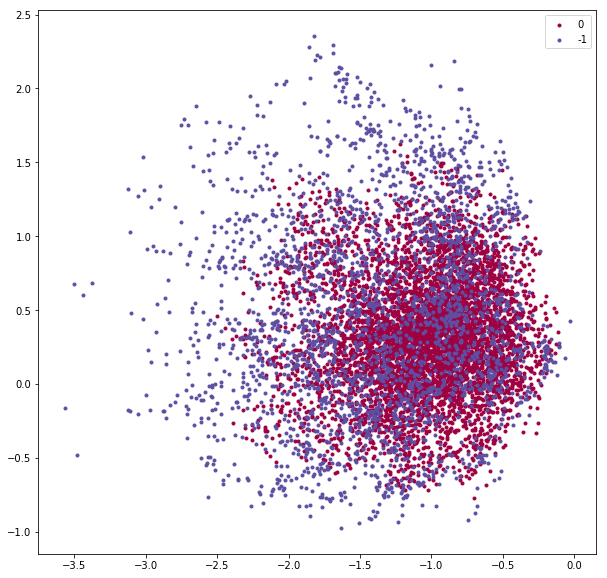

In [14]:
plt.figure(figsize=(10,10))
for k, col in zip(unique_labels, colors):
    if k == 0 or k == -1:
        cluster = tags[tags['cluster'] == k]
        plt.scatter(cluster[1], cluster[2], marker='.', color=col, label=k)
plt.legend()

In [15]:
cluster0 = tags[(tags['cluster'] == 0)]

In [16]:
cluster0.shape[0]

5916

In [18]:
def getStructuralMetrics(X, K):
    silhouette = []
    inertia = []

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=17).fit(X)
        s = silhouette_score(X, kmeans.labels_)
        i = kmeans.inertia_
        silhouette.append(s)
        inertia.append(i)
        
    return [silhouette, inertia]

In [35]:
def plotClusters(data, K, centroids, pcaComp = False):
    plt.figure(figsize=(12,12))
    for c in range(K):
        cluster = data[data['cluster'] == c]
        if pcaComp:
            plt.scatter(cluster['r1'], cluster['r2'], marker='.', label=c)
        else:
            plt.scatter(cluster[1], cluster[2], marker='.', label=c)
            plt.scatter(centroids[c][0], centroids[c][1], marker='o', color='black')
    plt.legend()

In [20]:
K = range(2, 15)
s, i = getStructuralMetrics(cluster0[range(1,9)], K)

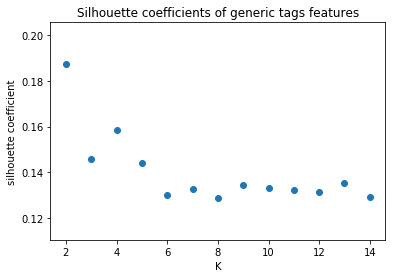

In [24]:
plt.title('Silhouette coefficients of generic tags features')
plt.xlabel('K')
plt.ylabel('silhouette coefficient')
plt.scatter(K, s)

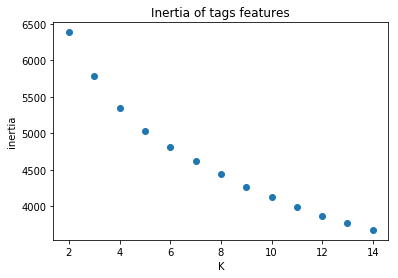

In [25]:
plt.title('Inertia of tags features')
plt.xlabel('K')
plt.ylabel('inertia')
plt.scatter(K, i)

In [38]:
K = 13
kmeans = KMeans(n_clusters=K, random_state=17).fit(cluster0[range(1,9)])
kmeanslabels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [39]:
cluster0['cluster'] = kmeanslabels

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


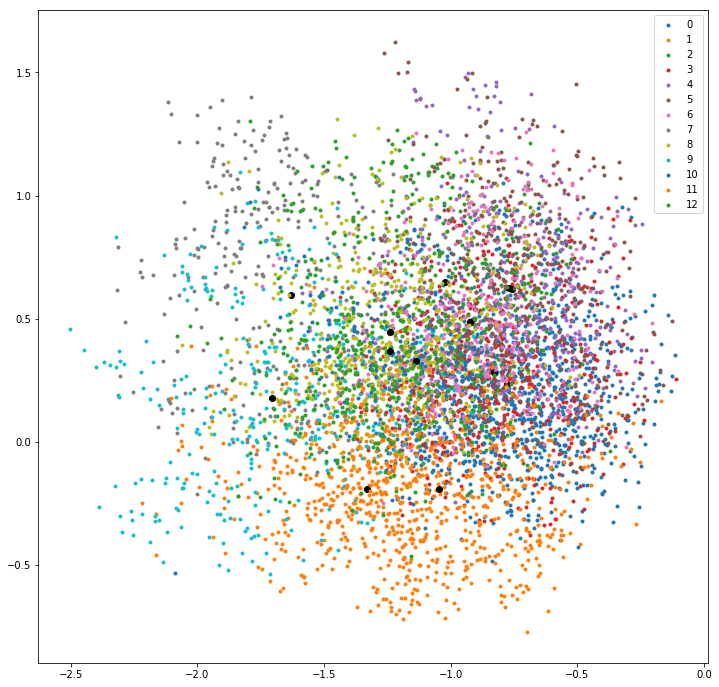

In [40]:
plotClusters(cluster0, K, centroids)

In [41]:
for c in range(K):
    print c, cluster0[cluster0['cluster'] == c].shape[0]

0 1089
1 362
2 208
3 579
4 377
5 488
6 418
7 366
8 573
9 333
10 171
11 519
12 433


In [42]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(cluster0[range(1,9)])

In [43]:
sum(pca.explained_variance_ratio_)

0.4455065088188931

In [44]:
X = pd.DataFrame(X_red, columns=['r1','r2'])
X['cluster'] = kmeanslabels

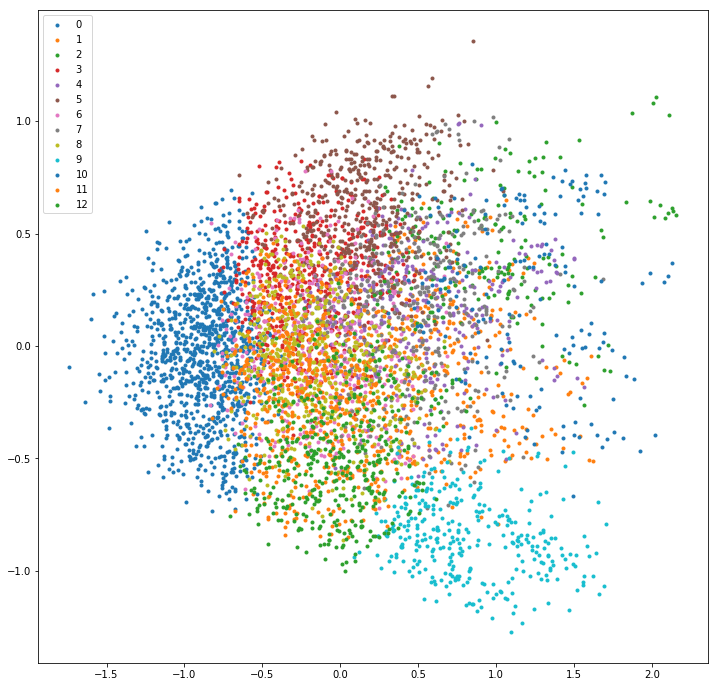

In [45]:
plotClusters(X, K, centroids, pcaComp=True)

Try to define the domain taking the top 20 for each cluster, ranked by distance from the centroid

In [63]:
def rankTags(data, centroid):
    temp = data
    temp['distance'] = data.apply(lambda x: np.linalg.norm(np.array(x[3:11]) - centroid), axis=1)
    temp.sort_values(by='distance', inplace=True)
    
    return temp

In [64]:
ranking = rankTags(cluster0[cluster0['cluster'] == 10], centroids[10])

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [84]:
N_top = 20
with open('output/2_step_tags_clusters.csv', 'w') as outfile:
    outfile.write('id_cluster\tdim\thashtags\n')
    for i in range(K):
        ranking = rankTags(cluster0[cluster0['cluster'] == i], centroids[i])
        topTag = list(ranking[:N_top]['content'])
        outfile.write('{}\t{}\t{}\n'.format(i, ranking.shape[0], ','.join(topTag)))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Compute participation as before

In [66]:
# extract list of tags for each SUBcluster
subclusterTags = {}
for c in range(K):
    cluster = cluster0[cluster0['cluster'] == c]
    subclusterTags[c] = set(cluster['content'])

In [69]:
# compute participation of each user in this SUBcluster of cluster 0
tempResult = []
for u in usedtags:
    u_vector = usedtags[u]
    
    if len(u_vector)>0:
        u_result = [u]
        for c in range(K):
            c_vector = subclusterTags[c]
            participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
            u_result.append(participation)
    else:
        u_result = [u]+[0 for i in range(K)]
    tempResult.append(tuple(u_result))

In [70]:
result_header = ['username']+[c for c in range(K)]
participationSubclusters = pd.DataFrame(tempResult, columns=result_header)

In [71]:
participationSubclusters.head()

,username,0,1,2,3,4,5,6,7,8,9,10,11,12
0,martaferrari9008,0.000000,0.000000,0.0,0.000000,0.5,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.000000
1,rsersale,0.235294,0.058824,0.0,0.470588,0.0,0.00,0.000000,0.117647,0.000000,0.0,0.000000,0.058824,0.000000
2,tlashab,0.375000,0.000000,0.0,0.125000,0.0,0.25,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,charr114,0.235294,0.000000,0.0,0.529412,0.0,0.00,0.176471,0.000000,0.000000,0.0,0.058824,0.000000,0.000000
4,catespin,0.352941,0.000000,0.0,0.117647,0.0,0.00,0.058824,0.000000,0.352941,0.0,0.000000,0.000000,0.058824


In [72]:
usedtags['martaferrari9008']

{'golf', 'interior'}

In [73]:
for c in range(K):
    print c, participationSubclusters[participationSubclusters[c] == 1.0].shape[0]

0 6
1 6
2 1
3 2
4 3
5 8
6 5
7 4
8 6
9 0
10 1
11 5
12 3


In [74]:
for c in range(K):
    print c, participationSubclusters[participationSubclusters[c] >= 0.5].shape[0]

0 72
1 34
2 13
3 40
4 33
5 33
6 26
7 32
8 35
9 18
10 11
11 30
12 44


In [85]:
participationSubclusters.to_csv('output/2_step_user_participation.csv', index=None)

In [82]:
with open('output/2_step_user_groups.csv', 'w') as outfile:
    outfile.write('id_cluster\tnum_users\tlist_users\n')
    idx = []
    for i in range(K):
        group = participationSubclusters[participationSubclusters[i] >= 0.5]
        idx = idx + list(group.index)
        group.sort_values(by=i, ascending = False, inplace=True)
        
        dim = group.shape[0]
        userlist = list(group.apply(lambda x: tuple((x['username'], x[i])), axis=1))
        outfile.write('{}\t{}\t{}\n'.format(i, dim, str(userlist).strip('[]')))
        
    blurryUsers = participationSubclusters.drop(idx)
    blurry_ulist = list(blurryUsers.apply(lambda x: x['username'], axis=1))
    outfile.write('-1\t{}\t{}\n'.format(blurryUsers.shape[0], ','.join(blurry_ulist)))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
